- medium: https://medium.com/@vineet.mundhra/loading-bert-with-tensorflow-hub-7f5a1c722565
- notebook: https://github.com/vineetm/tfhub-bert/blob/master/bert_tfhub.ipynb

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

## Labels

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df_financial = df_financial["Close"]

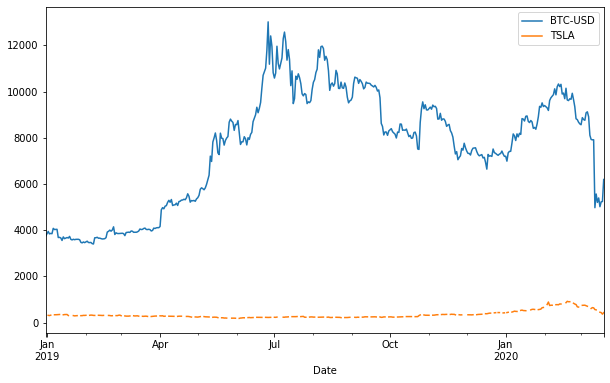

In [32]:
df_returns = df_financial.pct_change()
df_returns.plot(figsize = (10,6))

## Data processing

In [4]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)

def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [5]:
split_text = pd.DataFrame(df.maintext.apply(get_split))
split_text.index = pd.DatetimeIndex(df["date_google"])

In [56]:
def generate_data_for_tokenizer(split_text,target_series):
    labels_list = []
    dates = []
    for date, arrays in split_text.itertuples():
        dates.extend([date]* len(arrays))
    for date in dates:
        labels_list.append(target_series.loc[date])
    
    split_text_flat = split_text.values.flatten()
    sentence_list = [sentence for array in split_text_flat for sentence in array]
    
    labels = pd.DataFrame(labels_list, index = dates)
    sentences  = pd.DataFrame(sentence_list, index = dates)
    return sentences, labels
    

In [9]:
# proporcion  2020-01-01 test
1288/7649.0

0.16838802457837626

In [62]:
sentences.head()

,0
2019-01-01,Cryptocurrency exchange HitBTC has frozen its ...
2019-01-01,withdrawal rejects at the behest of HitBTC. Ex...
2019-01-01,funds deposited with a third party service on ...
2019-01-01,Abkhazia Temporarily Shuts Down 15 Mining Farm...
2019-01-01,"Abkhazian authorities explained the measure, w..."


In [170]:
from sklearn.model_selection import train_test_split

#train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size = 0.168)

## BERT 

In [12]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'
#module = hub.Module(BERT_URL)

'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'

In [13]:
bert_layer = hub.KerasLayer(BERT_URL,
 trainable=False)

In [14]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


In [15]:
def create_tokenizer(vocab_file='vocab.txt', do_lower_case=False):
    return bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


In [16]:
tokenizer = create_tokenizer(vocab_file)


In [17]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=200):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

In [234]:
max_seq_length = 200
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="segment_ids")

bert_inputs = [input_word_ids, input_mask, segment_ids]

bert_outputs = bert_layer(bert_inputs)

In [29]:
#model = Model(inputs= bert_inputs, outputs=bert_outputs)

In [19]:
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, 200)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, 200)


In [248]:
def build_model(max_seq_length):
    # Build model
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    #bert_inputs = {"input_word_ids" : in_id, "input_mask" : in_mask, "input_type_ids" : in_segment}



    # Instantiate the custom Bert Layer defined above
    pooled_output, sequence_output  = bert_layer(inputs = bert_inputs)
    # Build the rest of the classifier 
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(pooled_output)
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(dense)
    pred = tf.keras.layers.Dense(1, activation='linear', name = "output")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [244]:
df_diff = df_financial - df_financial.shift()


In [246]:
df_returns = df_financial.pct_change()
df_diff = df_financial - df_financial.shift()

sentences, labels = generate_data_for_tokenizer(split_text,df_diff["BTC-USD"])


threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]

In [249]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }
test_inputs = {
     "input_ids": np.array(test_input_ids, dtype = 'int64'),
     "input_mask": np.array(test_input_masks, dtype = 'int64'),
     "segment_ids": np.array(test_segment_ids, dtype = 'int64'),
     }
tr_labels = {
    "output" : train_labels.values.reshape(-1)
}
ts_labels = {
    "output" : test_labels.values.reshape(-1)
}
for k in test_inputs:
    test_inputs[k] = tf.cast(test_inputs[k], tf.int32)

In [236]:
model = build_model(200)

In [ ]:
ts_labels

In [292]:
history = model.fit(x = train_inputs, 
    y = tr_labels,
    validation_data=(test_inputs, ts_labels),
    epochs=35,
    batch_size=256
)

Train on 6361 samples, validate on 1288 samples
Epoch 1/35
6361/6361 [==============================] - ETA: 1:30 - loss: 12.53 - ETA: 1:26 - loss: 11.94 - ETA: 1:22 - loss: 12.12 - ETA: 1:18 - loss: 11.93 - ETA: 1:15 - loss: 11.46 - ETA: 1:11 - loss: 11.60 - ETA: 1:07 - loss: 11.66 - ETA: 1:03 - loss: 11.63 - ETA: 1:00 - loss: 11.74 - ETA: 56s - loss: 11.6361 - ETA: 52s - loss: 11.441 - ETA: 48s - loss: 11.430 - ETA: 44s - loss: 11.427 - ETA: 41s - loss: 11.344 - ETA: 37s - loss: 11.269 - ETA: 33s - loss: 11.279 - ETA: 29s - loss: 11.245 - ETA: 25s - loss: 11.109 - ETA: 22s - loss: 11.087 - ETA: 18s - loss: 11.137 - ETA: 14s - loss: 11.113 - ETA: 10s - loss: 11.168 - ETA: 7s - loss: 11.270 - ETA: 3s - loss: 11.23 - 113s 18ms/sample - loss: 11.2158 - val_loss: 12.9952
Epoch 2/35
6361/6361 [==============================] - ETA: 1:30 - loss: 11.50 - ETA: 1:26 - loss: 11.47 - ETA: 1:22 - loss: 11.18 - ETA: 1:19 - loss: 11.08 - ETA: 1:15 - loss: 11.31 - ETA: 1:11 - loss: 11.20 - ETA: 1:07

6361/6361 [==============================] - ETA: 1:30 - loss: 11.11 - ETA: 1:26 - loss: 11.30 - ETA: 1:22 - loss: 10.97 - ETA: 1:19 - loss: 11.04 - ETA: 1:15 - loss: 10.90 - ETA: 1:11 - loss: 11.11 - ETA: 1:07 - loss: 10.97 - ETA: 1:04 - loss: 11.00 - ETA: 1:00 - loss: 10.99 - ETA: 56s - loss: 11.1557 - ETA: 52s - loss: 11.082 - ETA: 48s - loss: 11.052 - ETA: 45s - loss: 11.061 - ETA: 41s - loss: 11.091 - ETA: 37s - loss: 11.236 - ETA: 33s - loss: 11.261 - ETA: 29s - loss: 11.268 - ETA: 26s - loss: 11.337 - ETA: 22s - loss: 11.348 - ETA: 18s - loss: 11.351 - ETA: 14s - loss: 11.359 - ETA: 10s - loss: 11.303 - ETA: 7s - loss: 11.222 - ETA: 3s - loss: 11.16 - 114s 18ms/sample - loss: 11.2158 - val_loss: 12.9952
Epoch 13/35
6361/6361 [==============================] - ETA: 1:30 - loss: 10.58 - ETA: 1:26 - loss: 10.92 - ETA: 1:23 - loss: 10.95 - ETA: 1:19 - loss: 11.23 - ETA: 1:15 - loss: 11.46 - ETA: 1:11 - loss: 11.37 - ETA: 1:07 - loss: 11.19 - ETA: 1:04 - loss: 11.21 - ETA: 1:00 - los

6361/6361 [==============================] - ETA: 1:30 - loss: 12.97 - ETA: 1:26 - loss: 12.27 - ETA: 1:23 - loss: 11.43 - ETA: 1:19 - loss: 11.36 - ETA: 1:15 - loss: 11.22 - ETA: 1:11 - loss: 10.99 - ETA: 1:07 - loss: 11.32 - ETA: 1:04 - loss: 11.33 - ETA: 1:00 - loss: 11.31 - ETA: 56s - loss: 11.2852 - ETA: 52s - loss: 11.300 - ETA: 48s - loss: 11.296 - ETA: 45s - loss: 11.325 - ETA: 41s - loss: 11.314 - ETA: 37s - loss: 11.288 - ETA: 33s - loss: 11.266 - ETA: 29s - loss: 11.304 - ETA: 26s - loss: 11.278 - ETA: 22s - loss: 11.252 - ETA: 18s - loss: 11.309 - ETA: 14s - loss: 11.310 - ETA: 10s - loss: 11.310 - ETA: 7s - loss: 11.263 - ETA: 3s - loss: 11.19 - 114s 18ms/sample - loss: 11.2158 - val_loss: 12.9952
Epoch 24/35
6361/6361 [==============================] - ETA: 1:30 - loss: 11.14 - ETA: 1:26 - loss: 11.57 - ETA: 1:23 - loss: 11.76 - ETA: 1:19 - loss: 11.72 - ETA: 1:15 - loss: 11.81 - ETA: 1:11 - loss: 11.65 - ETA: 1:07 - loss: 11.71 - ETA: 1:04 - loss: 11.70 - ETA: 1:00 - los

6361/6361 [==============================] - ETA: 1:30 - loss: 12.68 - ETA: 1:26 - loss: 11.79 - ETA: 1:22 - loss: 11.73 - ETA: 1:19 - loss: 11.61 - ETA: 1:15 - loss: 11.66 - ETA: 1:11 - loss: 11.53 - ETA: 1:07 - loss: 11.76 - ETA: 1:04 - loss: 11.57 - ETA: 1:00 - loss: 11.67 - ETA: 56s - loss: 11.7031 - ETA: 52s - loss: 11.631 - ETA: 48s - loss: 11.563 - ETA: 45s - loss: 11.520 - ETA: 41s - loss: 11.508 - ETA: 37s - loss: 11.463 - ETA: 33s - loss: 11.475 - ETA: 29s - loss: 11.479 - ETA: 26s - loss: 11.404 - ETA: 22s - loss: 11.392 - ETA: 18s - loss: 11.411 - ETA: 14s - loss: 11.391 - ETA: 10s - loss: 11.313 - ETA: 7s - loss: 11.320 - ETA: 3s - loss: 11.29 - 114s 18ms/sample - loss: 11.2158 - val_loss: 12.9952
Epoch 35/35
6361/6361 [==============================] - ETA: 1:30 - loss: 10.59 - ETA: 1:26 - loss: 11.07 - ETA: 1:22 - loss: 10.64 - ETA: 1:19 - loss: 10.65 - ETA: 1:15 - loss: 10.58 - ETA: 1:11 - loss: 10.75 - ETA: 1:07 - loss: 10.89 - ETA: 1:04 - loss: 10.77 - ETA: 1:00 - los

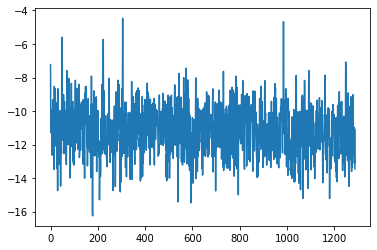

In [293]:
predictions = model.predict(test_inputs, batch_size=256)
plt.plot(predictions.flatten())

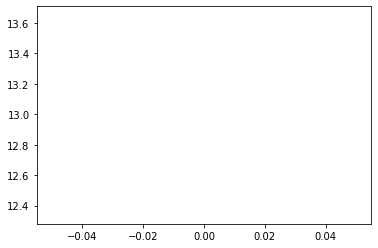

In [252]:
plt.plot(history.history["val_loss"])

In [294]:
print(max(predictions))
print(min(predictions))

[-4.463237]
[-16.249308]


In [295]:
test_labels["pred"] = predictions.flatten()

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [296]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_prices", "pred_prices"]

In [297]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_diff", "pred_diff"]

In [298]:
start = df_financial.loc["2020-01-01"]["BTC-USD"]
pred_prices =  [start]
for row in output_series.itertuples():
    next_value = pred_prices[-1] + row[2]
    pred_prices.append(next_value)
output_series["pred_prices"] = pred_prices[:-1]

In [ ]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_returns", "pred_returns"]

In [219]:
start = df_financial.loc["2020-01-01"]["BTC-USD"]
output_series['real_prices'] = start * (1 + output_series['real_returns']).cumprod()
output_series['pred_prices'] = start * (1 + output_series['pred_returns']/50).cumprod()

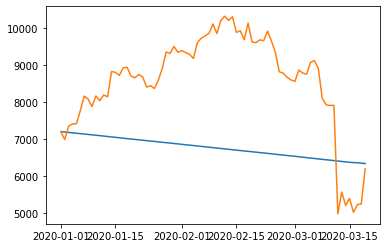

In [299]:
plt.plot(output_series["pred_prices"])
plt.plot(df_financial.loc["2020-01-01":]["BTC-USD"])


In [187]:
min(predictions.flatten())

82.760704

(array([  37.,   65.,  249., 1170., 3320., 1075.,  260.,   97.,   66.,
          22.]),
 array([-0.14085681, -0.10941511, -0.07797342, -0.04653172, -0.01509003,
         0.01635166,  0.04779336,  0.07923505,  0.11067675,  0.14211844,
         0.17356014]),
 <a list of 10 Patch objects>)

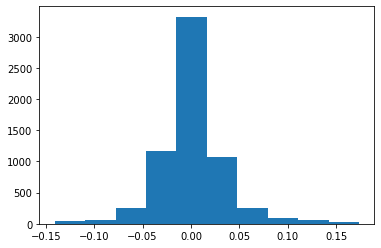

In [148]:
plt.hist(tr_labels["output"],bins = 10)

{'output': array([7200.17431641, 7200.17431641, 7200.17431641, ..., 6191.19287109,
        6191.19287109, 6191.19287109])}

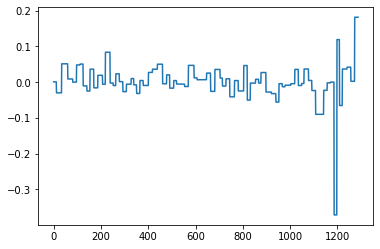

In [80]:
plt.plot(ts_labels["output"])

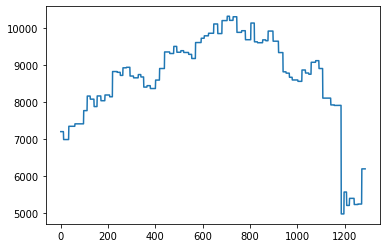

In [48]:
plt.plot(ts_labels["output"])

In [44]:
min(predictions)

array([2234.6895], dtype=float32)

In [152]:
model.save("40_epoch_bert_returns.hdf5")

In [258]:
test_model = build_model(max_seq_length)
test_model.load_weights('one_epoch_bert.hdf5')

In [260]:
test_model.evaluate(test_inputs, ts_labels)

1288/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [261]:
predictions

[0.002772992409574828, 0.0]

In [266]:
predictions = model.predict(test_inputs, batch_size=32)
plt.plot(predictions.flatten())

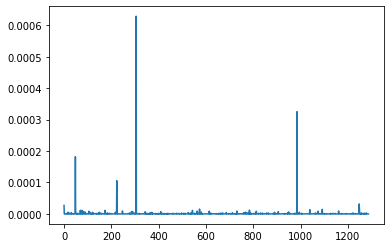

In [268]:
plt.plot(predictions.flatten())

In [274]:
bert.__name__

'bert'

In [271]:
min(predictions)

array([0.], dtype=float32)

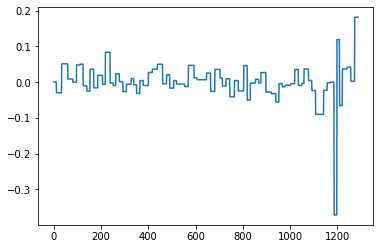

In [270]:
plt.plot(ts_labels["output"])